In [1]:
#注意事项:
#当运行本Notebook的程序后，如果要关闭Notebook，请选择菜单: File > Close and Halt 才能确实停止当前正在运行的程序，并且释放资源
#如果没有使用以上方法，只关闭此分页，程序仍在运行，未释放资源，当您打开并运行其他的Notebook，可能会发生错误

In [2]:
sc.master

u'spark://master:7077'

# 13.6	如何进行数据准备?

In [3]:
global Path    
if sc.master[0:5]=="local" :
   Path="file:/home/hduser/pythonsparkexample/PythonProject/"
else:   
   Path="hdfs://master:9000/user/hduser/"
#如果要在cluster模式运行(hadoop yarn 或Spark Stand alone)，请按照书上的说明，先把文件上传到HDFS目录

In [4]:
print("开始导入数据...")
rawDataWithHeader = sc.textFile(Path+"data/train.tsv")
rawDataWithHeader.take(2)

开始导入数据...


[u'"url"\t"urlid"\t"boilerplate"\t"alchemy_category"\t"alchemy_category_score"\t"avglinksize"\t"commonlinkratio_1"\t"commonlinkratio_2"\t"commonlinkratio_3"\t"commonlinkratio_4"\t"compression_ratio"\t"embed_ratio"\t"framebased"\t"frameTagRatio"\t"hasDomainLink"\t"html_ratio"\t"image_ratio"\t"is_news"\t"lengthyLinkDomain"\t"linkwordscore"\t"news_front_page"\t"non_markup_alphanum_characters"\t"numberOfLinks"\t"numwords_in_url"\t"parametrizedLinkRatio"\t"spelling_errors_ratio"\t"label"',
 u'"http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html"\t"4042"\t"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the

In [5]:
print("开始导入数据...")
rawDataWithHeader = sc.textFile(Path+"data/train.tsv")
header = rawDataWithHeader.first() 
rawData = rawDataWithHeader.filter(lambda x:x !=header)    
rData=rawData.map(lambda x: x.replace("\"", ""))    
lines = rData.map(lambda x: x.split("\t"))
print("共计：" + str(lines.count()) + "项")

开始导入数据...
共计：7395项


In [6]:
lines.first()[3:]

[u'business',
 u'0.789131',
 u'2.055555556',
 u'0.676470588',
 u'0.205882353',
 u'0.047058824',
 u'0.023529412',
 u'0.443783175',
 u'0',
 u'0',
 u'0.09077381',
 u'0',
 u'0.245831182',
 u'0.003883495',
 u'1',
 u'1',
 u'24',
 u'0',
 u'5424',
 u'170',
 u'8',
 u'0.152941176',
 u'0.079129575',
 u'0']

In [7]:
categoriesMap =lines.map(lambda fields: fields[3]) \
        .distinct().zipWithIndex().collectAsMap()

In [8]:
categoriesMap

{u'?': 6,
 u'arts_entertainment': 13,
 u'business': 1,
 u'computer_internet': 2,
 u'culture_politics': 3,
 u'gaming': 7,
 u'health': 5,
 u'law_crime': 4,
 u'recreation': 0,
 u'religion': 11,
 u'science_technology': 9,
 u'sports': 10,
 u'unknown': 8,
 u'weather': 12}

In [9]:
len(categoriesMap)

14

In [10]:
type(categoriesMap)

dict

In [11]:
import numpy as np
def extract_features(field,categoriesMap,featureEnd):
    #提取分类特征字段
    categoryIdx = categoriesMap[field[3]] 
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    #提取数值字段
    numericalFeatures=[convert_float(field)  for  field in field[4: featureEnd]]    
    #返回“分类特征字段”+“数值特征字段”
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))

In [12]:
def extract_label(field):
    label=(field[-1])
    return float(label)

In [13]:
labelRDD = lines.map( lambda r: extract_label(r))
print labelRDD.take(1)

[0.0]


In [14]:
from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: 
     LabeledPoint(
                extract_label(r),
                extract_features(r,categoriesMap,len(r) - 1)))

In [15]:
print lines.first()[3:]

[u'business', u'0.789131', u'2.055555556', u'0.676470588', u'0.205882353', u'0.047058824', u'0.023529412', u'0.443783175', u'0', u'0', u'0.09077381', u'0', u'0.245831182', u'0.003883495', u'1', u'1', u'24', u'0', u'5424', u'170', u'8', u'0.152941176', u'0.079129575', u'0']


In [16]:
labelpointRDD.take(1)

[LabeledPoint(0.0, [0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [17]:
(trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
print("将数据分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))


将数据分trainData:5917   validationData:743   testData:735


In [18]:
def PrepareData(sc): 
    #----------------------1.导入并转换数据-------------
    global Path    
    if sc.master[0:5]=="local" :
       Path="file:/home/hduser/pythonsparkexample/PythonProject/"
    else:   
       Path="hdfs://master:9000/user/hduser/"

    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"data/train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")
    #----------2.建立训练评估所需数据 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
                 extract_label(r), 
                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1)))
        
    #-----------3.以随机方式将数据分为3个部分并且返回-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("将数据分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #返回数据


In [19]:
(trainData, validationData, testData, categoriesMap) =PrepareData(sc)

开始导入数据...
共计：7395项
将数据分trainData:5897   validationData:736   testData:762


In [20]:
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[35] at RDD at PythonRDD.scala:48

# 13.7	如何训练模型?

In [21]:
from pyspark.mllib.tree import DecisionTree
model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)

# 13.8	如何使用模型进行预测?

In [22]:
def PredictData(sc,model,categoriesMap): 
    print("开始导入数据...")
    rawDataWithHeader = sc.textFile(Path+"data/test.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共计：" + str(lines.count()) + "项")
    dataRDD = lines.map(lambda r:  ( r[0]  ,
                            extract_features(r,categoriesMap,len(r) )))
    DescDict = {
           0: "暂时性网页(ephemeral)",
           1: "长青网页(evergreen)"
     }
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print " 网址：  " +str(data[0])+"\n" +\
                  "             ==>预测:"+ str(predictResult)+ \
                  " 说明:"+DescDict[predictResult] +"\n"
    

In [23]:
print("==========预测数据===============")
PredictData(sc, model, categoriesMap)

==========预测数据===============
开始导入数据...
共计：3171项
 网址：  http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://lolpics.se/18552-stun-grenade-ar
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.xcelerationfitness.com/treadmills.html
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
             ==>预测:0.0 说明:暂时性网页(ephemeral)

 网址：  http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
             ==>预测:1.0 说明:长青网页(evergreen)

 网址：  http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-wi

# 13.9	如何评估模型的准确率?

In [24]:
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels=score .zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(5)

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 1.0), (0.0, 1.0)]

In [25]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print "AUC="+str(metrics.areaUnderROC)

AUC=0.647716193459


In [26]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [27]:
AUC=evaluateModel(model, validationData)
print "AUC="+str(AUC)

AUC=0.647716193459


In [28]:
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print    "训练评估：使用参数" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需时间="+str(duration) + \
                 " 结果AUC = " + str(AUC) 
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

In [29]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)

训练评估：使用参数 impurity=entropy maxDepth=5 maxBins=5
 ==>所需时间=3.03691887856 结果AUC = 0.647716193459


In [30]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)

训练评估：使用参数 impurity=entropy maxDepth=5 maxBins=5
 ==>所需时间=4.73913788795 结果AUC = 0.670959944751


# 13.10	模型的训练参数如何影响准确率?

In [31]:
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10 ]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=3.92659020424 结果AUC = 0.64945194552
训练评估：使用参数 impurity=entropy maxDepth=10 maxBins=10
 ==>所需时间=2.7336370945 结果AUC = 0.651017815464


In [32]:
metrics

[(0.6494519455195438,
  3.9265902042388916,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 667 nodes),
 (0.6510178154637043,
  2.7336370944976807,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 617 nodes)]

In [33]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.649452,3.926590,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.651018,2.733637,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


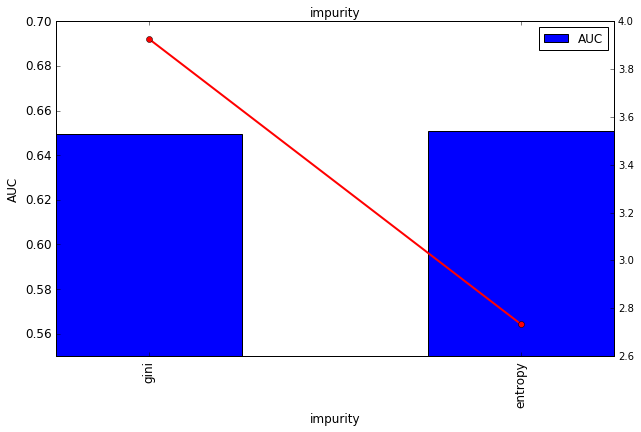

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline 
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.55,0.7])
ax.set_ylabel("AUC",fontsize=12)
ax2 = ax.twinx()
ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')
plt.show()

In [35]:
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()

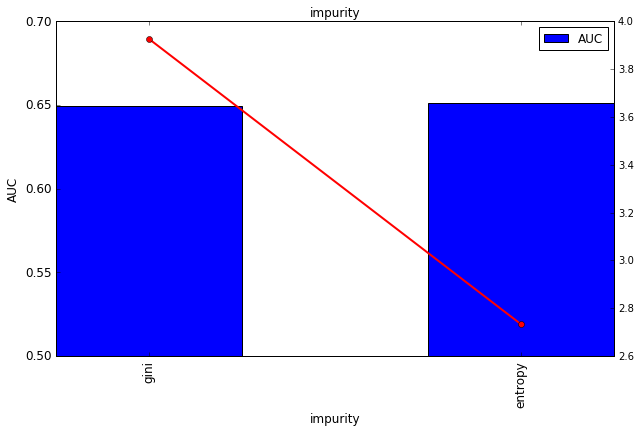

In [36]:
showchart(df,'impurity','AUC','duration',0.5,0.7 )

In [37]:
#定义evalParameter函数
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #训练评估参数
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #设置当前评估的参数
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #转换为Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #显示图形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )
    

训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=2.89534091949 结果AUC = 0.64945194552
训练评估：使用参数 impurity=entropy maxDepth=10 maxBins=10
 ==>所需时间=2.75364089012 结果AUC = 0.651017815464


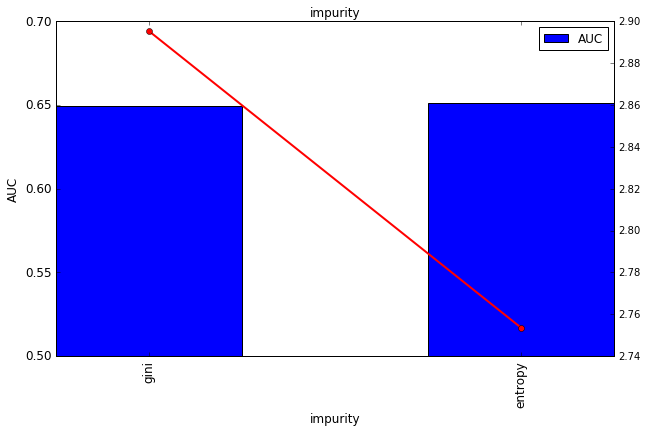

In [38]:
evalParameter(trainData, validationData,"impurity", 
                              impurityList=["gini", "entropy"],   
                              maxDepthList=[10],  
                              maxBinsList=[10 ])  

训练评估：使用参数 impurity=gini maxDepth=3 maxBins=10
 ==>所需时间=1.62775993347 结果AUC = 0.619360652347
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=10
 ==>所需时间=1.77454900742 结果AUC = 0.632146128165
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=2.25420403481 结果AUC = 0.64945194552
训练评估：使用参数 impurity=gini maxDepth=15 maxBins=10
 ==>所需时间=3.18579912186 结果AUC = 0.621199810914
训练评估：使用参数 impurity=gini maxDepth=20 maxBins=10
 ==>所需时间=3.56553721428 结果AUC = 0.617233432801
训练评估：使用参数 impurity=gini maxDepth=25 maxBins=10
 ==>所需时间=4.13618803024 结果AUC = 0.61433805064


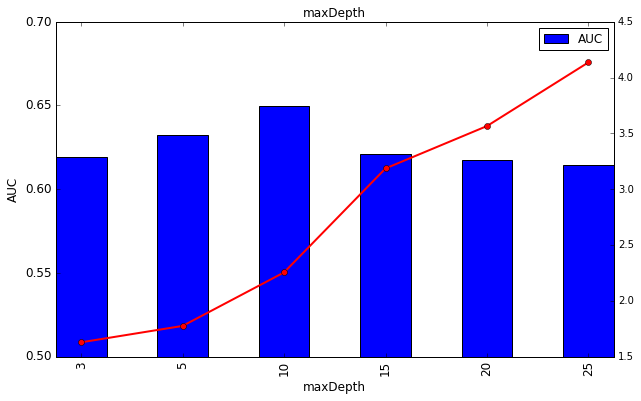

In [39]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

训练评估：使用参数 impurity=gini maxDepth=10 maxBins=3
 ==>所需时间=2.0863161087 结果AUC = 0.6194123556
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=5
 ==>所需时间=2.13967013359 结果AUC = 0.619057819009
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=10
 ==>所需时间=2.27937817574 结果AUC = 0.64945194552
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=50
 ==>所需时间=4.25811600685 结果AUC = 0.617632286466
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=100
 ==>所需时间=4.01602387428 结果AUC = 0.632781339557
训练评估：使用参数 impurity=gini maxDepth=10 maxBins=200
 ==>所需时间=2.74720883369 结果AUC = 0.652975152894


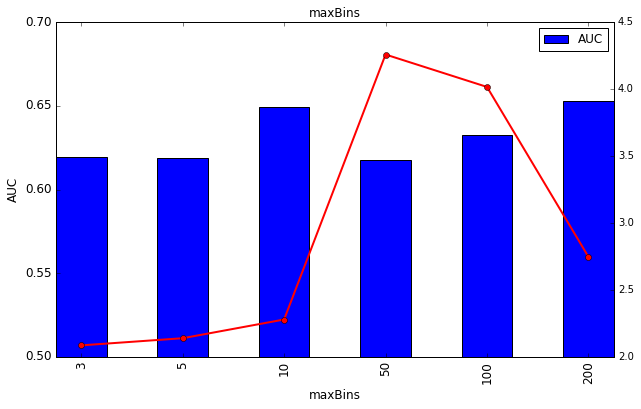

In [40]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

# 13.11	如何找出准确率最高的参数组合?

In [41]:
#定义evalAllParameter函数
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for循环训练评估所有参数组合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的参数组合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #显示调校后最佳参数组合      
    print("调校后最佳参数：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    结果AUC = " + str(bestParameter[0]))
    #返回最佳模型
    return bestParameter[5]

In [42]:
    print("-----所有参数训练评估找出最好的参数组合---------")  
    bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15, 20, 25], 
                          [3, 5, 10, 50, 100, 200 ])

-----所有参数训练评估找出最好的参数组合---------
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=3
 ==>所需时间=1.40247583389 结果AUC = 0.610364286347
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=5
 ==>所需时间=1.20420908928 结果AUC = 0.599344107306
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=10
 ==>所需时间=1.19195795059 结果AUC = 0.619360652347
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=50
 ==>所需时间=1.33700799942 结果AUC = 0.620697550743
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=100
 ==>所需时间=1.1923968792 结果AUC = 0.618112388099
训练评估：使用参数 impurity=gini maxDepth=3 maxBins=200
 ==>所需时间=1.2945971489 结果AUC = 0.619582237717
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=3
 ==>所需时间=1.37299108505 结果AUC = 0.610445534316
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=5
 ==>所需时间=1.51850700378 结果AUC = 0.646334977989
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=10
 ==>所需时间=1.38351011276 结果AUC = 0.632146128165
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=50
 ==>所需时间=1.31359910965 结果AUC = 0.626488315065
训练评估：使用参数 impurity=gini maxDepth=5 maxBins=100
 ==>所

# 13.12 如何确认是否Overfitting（过度训练）？

In [43]:
AUC=evaluateModel(model, testData)
print "AUC="+str(AUC)

AUC=0.670959944751
